In [1]:
import json
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import torch
from nnsight import CONFIG, LanguageModel
from torch.utils.data import DataLoader
from tqdm import tqdm

sys.path.append("../..")
from src.dataset import STORY_TEMPLATES, Dataset, Sample
from src.utils import env_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(10)

CONFIG.APP.REMOTE_LOGGING = True

os.environ["NDIF_KEY"] = env_utils.load_env_var("NDIF_KEY")
os.environ["HF_TOKEN"] = env_utils.load_env_var("HF_WRITE")

/disk/u/nikhil/.conda/envs/tomi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Synthetic Data

In [2]:
all_characters = json.load(
    open(
        os.path.join(
            env_utils.DEFAULT_DATA_DIR, "synthetic_entities", "characters.json"
        ),
        "r",
    )
)
all_objects = json.load(
    open(
        os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities", "bottles.json"),
        "r",
    )
)
all_states = json.load(
    open(
        os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities", "drinks.json"),
        "r",
    )
)

print(f"#characters: {len(all_characters)}")
print(f"#objects: {len(all_objects)}")
print(f"#states: {len(all_states)}")

#characters: 103
#objects: 21
#states: 23


# Loading model

In [3]:
is_remote = False

if is_remote:
    model = LanguageModel("meta-llama/Llama-3.1-70B")
else:
    model = LanguageModel(
        "meta-llama/Meta-Llama-3-70B-Instruct",
        device_map="auto",
        torch_dtype=torch.float16,
        dispatch=True,
    )

Loading checkpoint shards: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it]


# Sampling dataset

In [4]:
n_samples = 20
batch_size = 1

configs, samples = [], []
template_idx = 1
for _ in range(n_samples):
    template = STORY_TEMPLATES["templates"][template_idx]
    characters = random.sample(all_characters, 2)
    containers = random.sample(all_objects, 2)
    states = random.sample(all_states, 2)

    sample = Sample(
        template_idx=template_idx,
        characters=characters,
        containers=containers,
        states=states,
    )
    configs.append(sample)

dataset = Dataset(configs)

for i in range(n_samples):
    sample = dataset.__getitem__(i, set_container=1, set_character=0)
    samples.append(sample)

dataloader = DataLoader(samples, batch_size=1, shuffle=False)


In [5]:
idx = 0
data = samples[idx]
prompt = data["prompt"]
target = data["target"]
print(prompt, target)

Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Max and Karen are working in a busy restaurant. To complete an order, Max grabs an opaque tun and fills it with port. Then Karen grabs another opaque dispenser and fills it with water. Karen cannot observe Max's actions. Max can observe Karen's actions.
Question: What does Max believe the dispenser contains?
Answer: water


# Attn Knockout

In [6]:
n_rep = model.config.num_key_value_heads
n_heads = model.config.num_attention_heads
head_dim = model.config.hidden_size // model.config.num_attention_heads


def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : head_dim // 2]
    x2 = x[..., head_dim // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    X = hidden_states.shape
    batch, num_key_value_heads, slen, head_dim = X[0], X[1], X[2], X[3]
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(
        batch, num_key_value_heads, n_rep, slen, head_dim
    )
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

In [7]:
def apply_causal_mask(attn_scores, knockout_mask=None):
    ignore = torch.tensor(torch.finfo(torch.float16).min)

    # Apply causal mask
    mask = torch.triu(
        torch.ones(
            attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device
        ),
        diagonal=1,
    ).bool()
    attn_scores.masked_fill_(mask, ignore)

    attn_scores.masked_fill_(knockout_mask.to(attn_scores.device), ignore)

    return attn_scores

# Experiments

In [8]:
first_visibility_sent = [i for i in range(169, 176)]
second_visibility_sent = [i for i in range(176, 183)]
first_sent = [i for i in range(146, 157)]
second_sent = [i for i in range(158, 169)]

## Second Sentence + First Visibility Sentence

In [9]:
knockout = {}
for t in second_visibility_sent:
    knockout[t] = second_sent.copy()
    knockout[t] += first_visibility_sent.copy()

batch_size = 1
num_heads = model.config.num_attention_heads
tokens = model.tokenizer(samples[0]["prompt"], return_tensors="pt")["input_ids"]
q_len = tokens.size(1)

knockout_mask = torch.zeros(
    batch_size, num_heads, q_len, q_len, device=model.device, dtype=torch.bool
)

from_indices = []
to_indices = []

for from_pos, to_pos_list in knockout.items():
    for to_pos in to_pos_list:
        from_indices.append(from_pos)
        to_indices.append(to_pos)

from_indices = torch.tensor(from_indices)
to_indices = torch.tensor(to_indices)

for b in range(1, batch_size):
    knockout_mask[b, :, from_indices, to_indices] = True

for h in range(num_heads):
    knockout_mask[0, h, from_indices, to_indices] = True

In [10]:
second_sent_first_vis_sent = {}
patch_layers = [i for i in range(0, 32, 2)] + [
    i for i in range(40, model.config.num_hidden_layers, 10)
]

for layer_idx in patch_layers:
    correct, total = 0, 0
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        prompt = batch["prompt"][0]
        ans = batch["target"][0]
        input_tokens = model.tokenizer(prompt, return_tensors="pt").input_ids
        bsz, q_len = input_tokens.shape
        positions = torch.arange(q_len)
        positions = torch.tensor(positions).unsqueeze(0).repeat(bsz, 1)

        with torch.no_grad():
            with model.trace(prompt) as tracer:
                for l in range(layer_idx, model.config.num_hidden_layers):
                    query_states = model.model.layers[l].self_attn.q_proj.output
                    key_states = model.model.layers[l].self_attn.k_proj.output
                    value_states = model.model.layers[l].self_attn.v_proj.output

                    query_states = query_states.view(
                        bsz, q_len, -1, head_dim
                    ).transpose(1, 2)
                    key_states = key_states.view(bsz, q_len, -1, head_dim).transpose(
                        1, 2
                    )
                    value_states = value_states.view(
                        bsz, q_len, -1, head_dim
                    ).transpose(1, 2)

                    X = model.model.rotary_emb(value_states, positions)
                    cos, sin = X[0], X[1]
                    X = apply_rotary_pos_emb(
                        q=query_states, k=key_states, cos=cos, sin=sin
                    )
                    query_states, key_states = X[0], X[1]

                    key_states = repeat_kv(key_states, n_rep)
                    value_states = repeat_kv(value_states, n_rep)

                    attn_weights = torch.matmul(
                        query_states, key_states.transpose(2, 3)
                    ) / math.sqrt(head_dim)
                    attn_weights = apply_causal_mask(
                        attn_scores=attn_weights,
                        knockout_mask=knockout_mask,
                    )

                    attn_weights = torch.nn.functional.softmax(attn_weights, dim=-1)
                    attn_weights = torch.nn.functional.dropout(
                        attn_weights, p=0.0, training=False
                    )
                    attn_output = torch.matmul(attn_weights, value_states)
                    attn_output = attn_output.transpose(1, 2).contiguous()
                    attn_output = attn_output.reshape(bsz, q_len, -1)

                    model.model.layers[l].self_attn.o_proj.input = attn_output

                pred = model.lm_head.output[:, -1].argmax(dim=-1).item().save()

            # print(
            #     f"Prediction: {model.tokenizer.decode([pred]).lower().strip()} | Target: {ans}"
            # )
            if model.tokenizer.decode([pred]).lower().strip() == ans:
                correct += 1
            total += 1

    print(f"Layer: {layer_idx} | Accuracy: {round(correct / total, 2)}")

    second_sent_first_vis_sent[layer_idx] = round(correct / total, 2)

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1897831/462571743.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positions = torch.tensor(positions).unsqueeze(0).repeat(bsz, 1)
100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


Layer: 2 | Accuracy: 0.0


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Layer: 4 | Accuracy: 0.05


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Layer: 6 | Accuracy: 0.0


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Layer: 8 | Accuracy: 0.0


100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


Layer: 10 | Accuracy: 0.0


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Layer: 12 | Accuracy: 0.0


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Layer: 14 | Accuracy: 0.0


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Layer: 16 | Accuracy: 0.0


100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Layer: 18 | Accuracy: 0.0


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Layer: 20 | Accuracy: 0.05


100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


Layer: 22 | Accuracy: 0.05


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Layer: 24 | Accuracy: 0.35


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Layer: 26 | Accuracy: 0.85


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Layer: 28 | Accuracy: 1.0


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Layer: 30 | Accuracy: 1.0


100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Layer: 40 | Accuracy: 1.0


100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


Layer: 50 | Accuracy: 1.0


100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Layer: 60 | Accuracy: 1.0


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]

Layer: 70 | Accuracy: 1.0


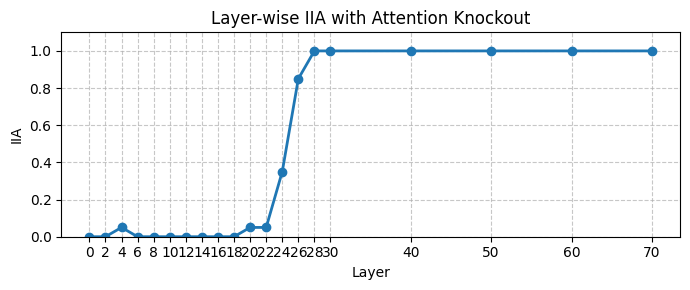

In [11]:
# Visualize second_sent_first_vis_sent as a line plot
plt.figure(figsize=(7, 3))
layers = list(second_sent_first_vis_sent.keys())
accuracies = list(second_sent_first_vis_sent.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Layer-wise IIA with Attention Knockout")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

## First Visibility Sentence

In [12]:
knockout = {}
for t in second_visibility_sent:
    knockout[t] = first_visibility_sent.copy()

batch_size = 1
num_heads = model.config.num_attention_heads
tokens = model.tokenizer(samples[0]["prompt"], return_tensors="pt")["input_ids"]
q_len = tokens.size(1)

knockout_mask = torch.zeros(
    batch_size, num_heads, q_len, q_len, device=model.device, dtype=torch.bool
)

from_indices = []
to_indices = []

for from_pos, to_pos_list in knockout.items():
    for to_pos in to_pos_list:
        from_indices.append(from_pos)
        to_indices.append(to_pos)

from_indices = torch.tensor(from_indices)
to_indices = torch.tensor(to_indices)

for b in range(1, batch_size):
    knockout_mask[b, :, from_indices, to_indices] = True

for h in range(num_heads):
    knockout_mask[0, h, from_indices, to_indices] = True

In [13]:
accs_first_vis_sent = {}
patch_layers = [i for i in range(0, 32, 2)] + [
    i for i in range(40, model.config.num_hidden_layers, 10)
]

for layer_idx in patch_layers:
    correct, total = 0, 0
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        prompt = batch["prompt"][0]
        ans = batch["target"][0]
        input_tokens = model.tokenizer(prompt, return_tensors="pt").input_ids
        bsz, q_len = input_tokens.shape
        positions = torch.arange(q_len)
        positions = torch.tensor(positions).unsqueeze(0).repeat(bsz, 1)

        with torch.no_grad():
            with model.trace(prompt) as tracer:
                for l in range(layer_idx, model.config.num_hidden_layers):
                    query_states = model.model.layers[l].self_attn.q_proj.output
                    key_states = model.model.layers[l].self_attn.k_proj.output
                    value_states = model.model.layers[l].self_attn.v_proj.output

                    query_states = query_states.view(
                        bsz, q_len, -1, head_dim
                    ).transpose(1, 2)
                    key_states = key_states.view(bsz, q_len, -1, head_dim).transpose(
                        1, 2
                    )
                    value_states = value_states.view(
                        bsz, q_len, -1, head_dim
                    ).transpose(1, 2)

                    X = model.model.rotary_emb(value_states, positions)
                    cos, sin = X[0], X[1]
                    X = apply_rotary_pos_emb(
                        q=query_states, k=key_states, cos=cos, sin=sin
                    )
                    query_states, key_states = X[0], X[1]

                    key_states = repeat_kv(key_states, n_rep)
                    value_states = repeat_kv(value_states, n_rep)

                    attn_weights = torch.matmul(
                        query_states, key_states.transpose(2, 3)
                    ) / math.sqrt(head_dim)
                    attn_weights = apply_causal_mask(
                        attn_scores=attn_weights,
                        knockout_mask=knockout_mask,
                    )

                    attn_weights = torch.nn.functional.softmax(attn_weights, dim=-1)
                    attn_weights = torch.nn.functional.dropout(
                        attn_weights, p=0.0, training=False
                    )
                    attn_output = torch.matmul(attn_weights, value_states)
                    attn_output = attn_output.transpose(1, 2).contiguous()
                    attn_output = attn_output.reshape(bsz, q_len, -1)

                    model.model.layers[l].self_attn.o_proj.input = attn_output

                pred = model.lm_head.output[:, -1].argmax(dim=-1).item().save()

            # print(
            #     f"Prediction: {model.tokenizer.decode([pred]).lower().strip()} | Target: {ans}"
            # )
            if model.tokenizer.decode([pred]).lower().strip() == ans:
                correct += 1
            total += 1

    print(f"Layer: {layer_idx} | Accuracy: {round(correct / total, 2)}")

    accs_first_vis_sent[layer_idx] = round(correct / total, 2)

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1897831/2939801609.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positions = torch.tensor(positions).unsqueeze(0).repeat(bsz, 1)
100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Layer: 0 | Accuracy: 0.05


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Layer: 2 | Accuracy: 0.15


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Layer: 4 | Accuracy: 0.4


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Layer: 6 | Accuracy: 0.35


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Layer: 8 | Accuracy: 0.15


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Layer: 10 | Accuracy: 0.05


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Layer: 12 | Accuracy: 0.25


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Layer: 14 | Accuracy: 0.3


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Layer: 16 | Accuracy: 0.35


100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Layer: 18 | Accuracy: 0.25


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Layer: 20 | Accuracy: 0.65


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


Layer: 22 | Accuracy: 1.0


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Layer: 24 | Accuracy: 1.0


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Layer: 26 | Accuracy: 1.0


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Layer: 28 | Accuracy: 1.0


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Layer: 30 | Accuracy: 1.0


100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Layer: 40 | Accuracy: 1.0


100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


Layer: 50 | Accuracy: 1.0


100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Layer: 60 | Accuracy: 1.0


100%|██████████| 20/20 [00:06<00:00,  2.91it/s]

Layer: 70 | Accuracy: 1.0


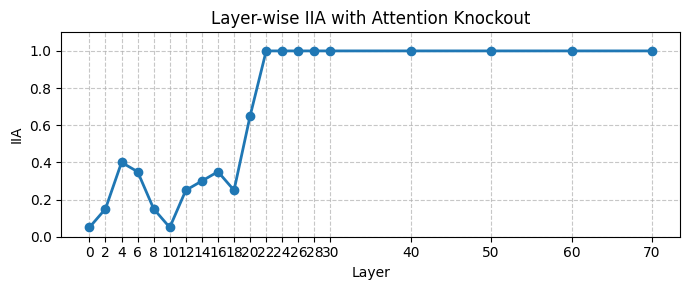

In [14]:
# Visualize accs_first_vis_sent as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_first_vis_sent.keys())
accuracies = list(accs_first_vis_sent.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Layer-wise IIA with Attention Knockout")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Second Story Sentence

In [15]:
knockout = {}
for t in second_visibility_sent:
    knockout[t] = second_sent.copy()

batch_size = 1
num_heads = model.config.num_attention_heads
tokens = model.tokenizer(samples[0]["prompt"], return_tensors="pt")["input_ids"]
q_len = tokens.size(1)

knockout_mask = torch.zeros(
    batch_size, num_heads, q_len, q_len, device=model.device, dtype=torch.bool
)

from_indices = []
to_indices = []

for from_pos, to_pos_list in knockout.items():
    for to_pos in to_pos_list:
        from_indices.append(from_pos)
        to_indices.append(to_pos)

from_indices = torch.tensor(from_indices)
to_indices = torch.tensor(to_indices)

for b in range(1, batch_size):
    knockout_mask[b, :, from_indices, to_indices] = True

for h in range(num_heads):
    knockout_mask[0, h, from_indices, to_indices] = True

In [16]:
accs_second_sent = {}
patch_layers = [i for i in range(0, 32, 2)] + [
    i for i in range(40, model.config.num_hidden_layers, 10)
]

for layer_idx in patch_layers:
    correct, total = 0, 0
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        prompt = batch["prompt"][0]
        ans = batch["target"][0]
        input_tokens = model.tokenizer(prompt, return_tensors="pt").input_ids
        bsz, q_len = input_tokens.shape
        positions = torch.arange(q_len)
        positions = torch.tensor(positions).unsqueeze(0).repeat(bsz, 1)

        with torch.no_grad():
            with model.trace(prompt) as tracer:
                for l in range(layer_idx, model.config.num_hidden_layers):
                    query_states = model.model.layers[l].self_attn.q_proj.output
                    key_states = model.model.layers[l].self_attn.k_proj.output
                    value_states = model.model.layers[l].self_attn.v_proj.output

                    query_states = query_states.view(
                        bsz, q_len, -1, head_dim
                    ).transpose(1, 2)
                    key_states = key_states.view(bsz, q_len, -1, head_dim).transpose(
                        1, 2
                    )
                    value_states = value_states.view(
                        bsz, q_len, -1, head_dim
                    ).transpose(1, 2)

                    X = model.model.rotary_emb(value_states, positions)
                    cos, sin = X[0], X[1]
                    X = apply_rotary_pos_emb(
                        q=query_states, k=key_states, cos=cos, sin=sin
                    )
                    query_states, key_states = X[0], X[1]

                    key_states = repeat_kv(key_states, n_rep)
                    value_states = repeat_kv(value_states, n_rep)

                    attn_weights = torch.matmul(
                        query_states, key_states.transpose(2, 3)
                    ) / math.sqrt(head_dim)
                    attn_weights = apply_causal_mask(
                        attn_scores=attn_weights,
                        knockout_mask=knockout_mask,
                    )

                    attn_weights = torch.nn.functional.softmax(attn_weights, dim=-1)
                    attn_weights = torch.nn.functional.dropout(
                        attn_weights, p=0.0, training=False
                    )
                    attn_output = torch.matmul(attn_weights, value_states)
                    attn_output = attn_output.transpose(1, 2).contiguous()
                    attn_output = attn_output.reshape(bsz, q_len, -1)

                    model.model.layers[l].self_attn.o_proj.input = attn_output

                pred = model.lm_head.output[:, -1].argmax(dim=-1).item().save()

            # print(
            #     f"Prediction: {model.tokenizer.decode([pred]).lower().strip()} | Target: {ans}"
            # )
            if model.tokenizer.decode([pred]).lower().strip() == ans:
                correct += 1
            total += 1

    print(f"Layer: {layer_idx} | Accuracy: {round(correct / total, 2)}")

    accs_second_sent[layer_idx] = round(correct / total, 2)

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1897831/2119420221.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positions = torch.tensor(positions).unsqueeze(0).repeat(bsz, 1)
100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Layer: 0 | Accuracy: 0.2


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Layer: 2 | Accuracy: 0.15


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Layer: 4 | Accuracy: 0.2


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Layer: 6 | Accuracy: 0.2


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Layer: 8 | Accuracy: 0.2


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Layer: 10 | Accuracy: 0.2


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Layer: 12 | Accuracy: 0.2


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Layer: 14 | Accuracy: 0.2


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Layer: 16 | Accuracy: 0.3


100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Layer: 18 | Accuracy: 0.5


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Layer: 20 | Accuracy: 0.6


100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


Layer: 22 | Accuracy: 0.75


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Layer: 24 | Accuracy: 1.0


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Layer: 26 | Accuracy: 1.0


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Layer: 28 | Accuracy: 1.0


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Layer: 30 | Accuracy: 1.0


100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Layer: 40 | Accuracy: 1.0


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Layer: 50 | Accuracy: 1.0


100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Layer: 60 | Accuracy: 1.0


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]

Layer: 70 | Accuracy: 1.0


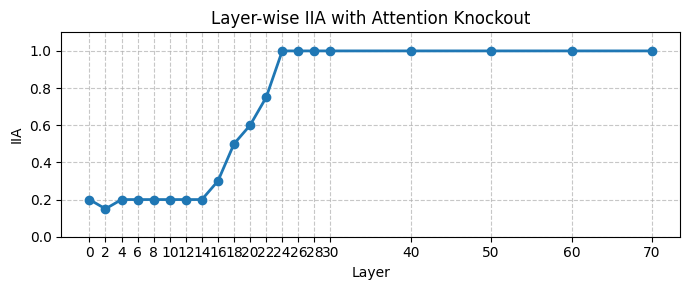

In [17]:
# Visualize accs_second_sent as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_second_sent.keys())
accuracies = list(accs_second_sent.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Layer-wise IIA with Attention Knockout")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()